In [1]:
# Initialize the MNIST dataset
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = torchvision.datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)

# Download and load the test data
testset = torchvision.datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=256, shuffle=True)

# Let's first build a CNN.
# CNN architecture for MNIST dataset
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)   # input shape (1, 28, 28), output shape (6, 24, 24)
        x = self.relu(x)    # input shape (6, 24, 24), output shape (6, 24, 24)
        x = self.max_pool(x)   # input shape (6, 24, 24), output shape (6, 12, 12)
        x = self.conv2(x)   # input shape (6, 12, 12), output shape (16, 8, 8)
        x = self.relu(x)    # input shape (16, 8, 8), output shape (16, 8, 8)
        x = self.max_pool(x)   # input shape (16, 8, 8), output shape (16, 4, 4)
        x = x.view(-1, 16*4*4)  # input shape (16, 4, 4), output shape (256)
        x = self.fc1(x)     # input shape (256), output shape (120)
        x = self.relu(x)    # input shape (120), output shape (120)
        x = self.fc2(x)     # input shape (120), output shape (84)
        x = self.relu(x)    # input shape (84), output shape (84)
        x = self.fc3(x)     # input shape (84), output shape (10)
        return x

# Initialize the model
model = CNN().to(device)

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Train the model with the training accuracy as output
loss_list = []
acc_list = []
for epoch in range(10):
    correct=0
    total=0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.3f, training accuracy %.2f' % (epoch + 1, i + 1, running_loss / 1000, 100 * correct / total))
            running_loss = 0.0
    loss_list.append(running_loss)
    acc_list.append(100 * correct / total)
    scheduler.step()

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

# Save the model
PATH = './cnn_mnist.pth'
torch.save(model.state_dict(), PATH)

# save the loss and accuracy using pickle
import pickle
with open('loss_list.pkl', 'wb') as f:
    pickle.dump(loss_list, f)
with open('acc_list.pkl', 'wb') as f:
    pickle.dump(acc_list, f)






100%|██████████| 9912422/9912422 [00:02<00:00, 3635304.71it/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 4651372.49it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3519512.53it/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12751357.94it/s]


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

[1,     1] loss: 0.002, training accuracy 6.64
[1,   101] loss: 0.173, training accuracy 47.60
[1,   201] loss: 0.034, training accuracy 68.34
[2,     1] loss: 0.000, training accuracy 94.53
[2,   101] loss: 0.016, training accuracy 95.07
[2,   201] loss: 0.012, training accuracy 95.62
[3,     1] loss: 0.000, training accuracy 96.48
[3,   101] loss: 0.009, training accuracy 97.12
[3,   201] loss: 0.009, training accuracy 97.24
[4,     1] loss: 0.000, training accuracy 96.88
[4,   101] loss: 0.007, training accuracy 97.74
[4,   201] loss: 0.007, training accuracy 97.76
[5,     1] loss: 0.000, training accuracy 97.66
[5,   101] loss: 0.006, training accuracy 98.11
[5,   201] loss: 0.005, training accuracy 98.23
[6,     1] loss: 0.000, training accuracy 98.05
[6,   101] loss: 0.005, training accuracy 98.38
[6,   201] loss: 0.005, training accuracy 98.42
[7,     1] loss: 0.000, training accuracy 99.22
[7,   

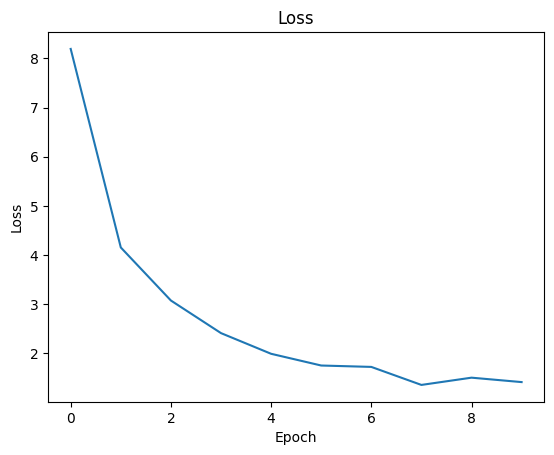

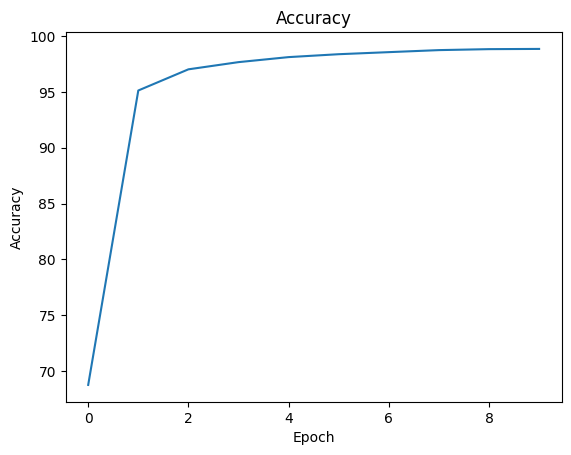

In [ ]:
# load the loss and accuracy from pickle
import pickle
with open('loss_list.pkl', 'rb') as f:
    loss_list = pickle.load(f)
with open('acc_list.pkl', 'rb') as f:
    acc_list = pickle.load(f)

# plot the loss and accuracy
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_list)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('loss.png')

plt.figure()
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('accuracy.png')

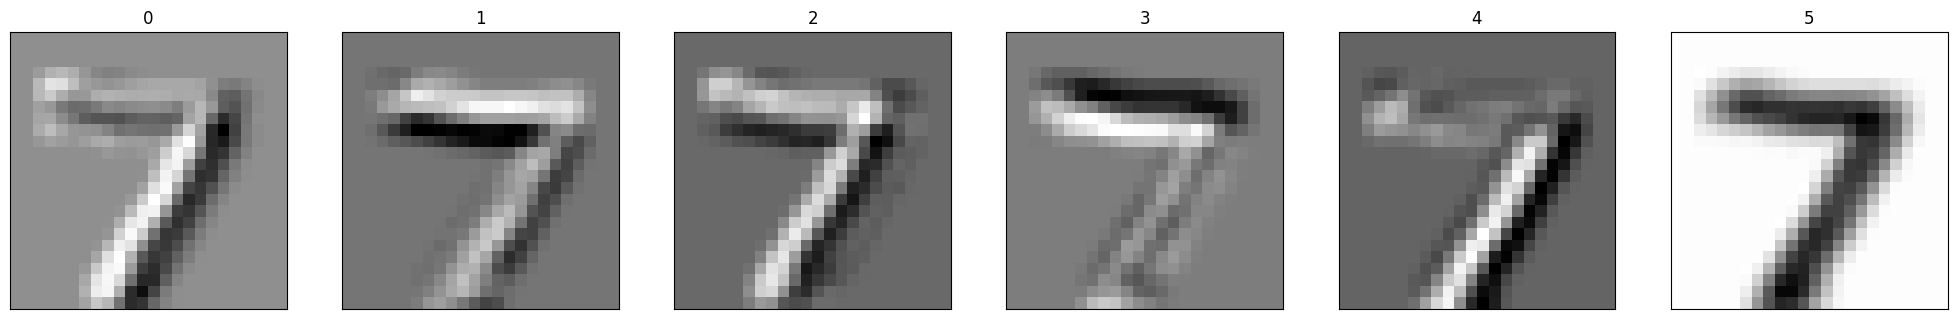

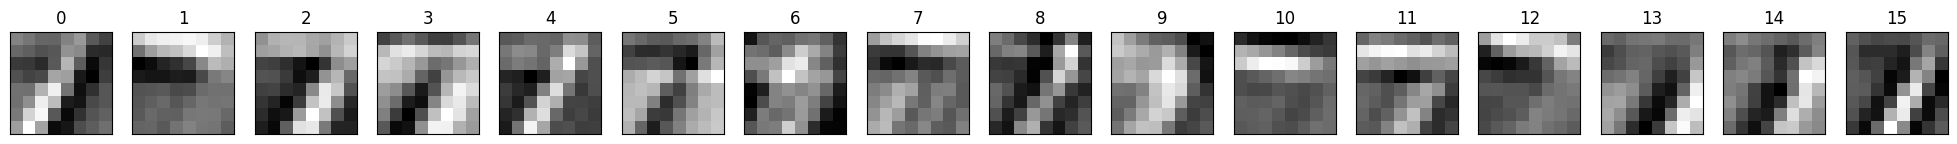

In [ ]:
# visualize the feature of the model

import torch
import torch.nn as nn

# define the model
# CNN architecture for MNIST dataset
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)   # input shape (1, 28, 28), output shape (6, 24, 24)
        x = self.relu(x)    # input shape (6, 24, 24), output shape (6, 24, 24)
        x = self.max_pool(x)   # input shape (6, 24, 24), output shape (6, 12, 12)
        x = self.conv2(x)   # input shape (6, 12, 12), output shape (16, 8, 8)
        x = self.relu(x)    # input shape (16, 8, 8), output shape (16, 8, 8)
        x = self.max_pool(x)   # input shape (16, 8, 8), output shape (16, 4, 4)
        x = x.view(-1, 16*4*4)  # input shape (16, 4, 4), output shape (256)
        x = self.fc1(x)     # input shape (256), output shape (120)
        x = self.relu(x)    # input shape (120), output shape (120)
        x = self.fc2(x)     # input shape (120), output shape (84)
        x = self.relu(x)    # input shape (84), output shape (84)
        x = self.fc3(x)     # input shape (84), output shape (10)
        return x

# load the model
model = CNN()
model.load_state_dict(torch.load('cnn_mnist.pth'))

# visualize the feature of the model
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# load the test dataset
test_dataset = datasets.MNIST(root='./MNIST_data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# get the first image and label
images, labels = next(iter(test_loader))

# get the feature of the first image
feature = model.conv1(images)
feature = feature.view(feature.size(1), feature.size(2), feature.size(3))
feature = feature.data.numpy()

# plot the feature
fig = plt.figure(figsize=(25, 4))
for i in np.arange(6):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(feature[i]), cmap='gray')
    ax.set_title(str(i))
plt.savefig('feature_conv1.png')  # save the feature image

# get the feature after conv2 of the first image
feature = model.conv2(model.max_pool(model.relu(model.conv1(images))))
feature = feature.view(feature.size(1), feature.size(2), feature.size(3))
feature = feature.data.numpy()

# plot the feature
fig = plt.figure(figsize=(25, 4))
for i in np.arange(16):
    ax = fig.add_subplot(1, 16, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(feature[i]), cmap='gray')
    ax.set_title(str(i))
plt.savefig('feature_conv2.png')  # save the feature image